In [44]:
#εισαγωγή βιβλιοθηκών - πακέτων
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight

nclass = 12
csv_file_path = 'https://raw.githubusercontent.com/kdemertzis/EKPA/refs/heads/main/Data/pcap_data.csv'


In [45]:
def loadDataset():
    # Put dataset path here !
    data = pd.read_csv(csv_file_path)
    print(data.describe())

    X = data.drop('target', axis=1).values
    y = data['target'].values

    return X, y

In [46]:
# -- LOAD DATA -----------------------------------------------------------------
X, y = loadDataset()

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Test data 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

# Train 70%, Validation%10
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, stratify=y_train)

train_data, train_labelp, val_data, val_labelp, test_data, test_labelp = X_train.astype(
    'float32'), y_train.astype('int32'),  X_val.astype('float32'), y_val.astype(
        'int32'),  X_test.astype('float32'), y_test.astype('int32')

       Avg_syn_flag  Avg_urg_flag  Avg_fin_flag  Avg_ack_flag  Avg_psh_flag  \
count  14967.000000  14967.000000  14967.000000  14967.000000  14967.000000   
mean       0.022377      1.326875     -0.005879     -0.002943     -0.006653   
std        2.915670      2.444476      1.005576      0.997667      1.004132   
min       -9.193078     -8.704301     -4.130541     -4.388453     -3.656687   
25%       -2.138833     -0.092510     -0.695776     -0.676355     -0.670314   
50%       -0.097278      1.575516      0.002692     -0.005591     -0.012705   
75%        2.098545      2.960918      0.663399      0.672271      0.668487   
max       11.341321     10.442542      4.616726      3.780323      3.820403   

       Avg_rst_flag   Avg_DNS_pkt   Avg_TCP_pkt   Avg_UDP_pkt  Avg_ICMP_pkt  \
count  14967.000000  14967.000000  14967.000000  14967.000000  14967.000000   
mean      -1.321141      0.009104     -1.341000     -0.664188     -0.018708   
std        2.390749      0.993520      2.580195    

In [47]:
# to_categorical
train_label = to_categorical(train_labelp, nclass)
val_label   = to_categorical(val_labelp,   nclass)
test_label  = to_categorical(test_labelp,  nclass)

print('train_data.shape=', train_data.shape)
print('test_data.shape=',  test_data.shape)
print('test_data.shape=',  val_data.shape)

#get the number of features
inshape=train_data.shape[1]

# Class balancing weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(
                                                      train_labelp),
                                                  y=train_labelp)


class_weights = {i: class_weights[i] for i in range(len(class_weights))}

train_data.shape= (10476, 25)
test_data.shape= (2994, 25)
test_data.shape= (1497, 25)


In [48]:
# -- CALLBACKS -----------------------------------------------------------------
earlyStopping = EarlyStopping(monitor='val_loss',
                              patience=30,
                              verbose=0,
                              mode='min')

modelCheckPoint = ModelCheckpoint('./savemodels/model5class.weights.{epoch:03d}-{val_acc:.4f}.hdf5.keras',
                                  save_best_only=True,
                                  monitor='val_acc',
                                  mode='max')

In [49]:
#συνάρτηση δημιουργίας και εκπαίδευσης νευρωνικού δικτύου
def create_and_train_model(input_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [50]:
#συνάρτηση αξιολόγησης μοντέλου και εκτύπωσης αποτελέσματων κατηγοριοποίησης
def evaluate_model(model, X_test, y_test):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    accuracy = classification_report(y_test, y_pred, output_dict=True)
    return accuracy['accuracy']

In [51]:
#συνάρτηση προσομοίωσης "λ" αρχιτεκτονικής με επανεκπαίδευση μετά από πλήθος ροών δεδομένων (streaming lambda architecture with periodic retraining)
def simulate_streaming_lambda_architecture(model, scaler, batch_size=500, retrain_every_batches=800, total_batches=8000):
    batch_counter = 0
    train_accuracies = []
    test_accuracies = []

    while batch_counter < total_batches:
        #φόρτωση συνόλου δεδομένων από csv αρχείο
        X, y = loadDataset()

        #τυποποίηση (standardize) δεδομένων
        X = scaler.transform(X)

        #κατάτμηση δεδομένων σε ροές (batches)
        for i in range(0, len(X), batch_size):
            batch_counter += 1
            X_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]

            #εκπαίδευση μοντέλου με κάθε ροή δεδομένων
            model.train_on_batch(X_batch, y_batch)

            #περιοδική εκπαίδευση μοντέλου με όλα τα δεδομένα
            if batch_counter % retrain_every_batches == 0:
                #τμηματοποίηση δεδομένων σε σύνολα εκπαίδευσης και δοκιμών
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

                #επανεκπαίδευση μοντέλου με όλα τα δεδομένα
                model = create_and_train_model(X_train.shape[1])
                model.fit(X_train, y_train, epochs=5, batch_size=64)  # Train for a few epochs

                #αποθήκευση των βαρών (weights) του μοντέλου για μελλοντική επανεκπαίδευση
                model.save('model_weights.keras')

                #αξιολόγηση του μοντέλου στα σύνολα εκπαίδευσης και δοκιμών
                train_accuracy = evaluate_model(model, X_train, y_train)
                test_accuracy = evaluate_model(model, X_test, y_test)

                train_accuracies.append(train_accuracy)
                test_accuracies.append(test_accuracy)

                print(f"Batch {batch_counter}, Training Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

    #εκτύπωση γραφικής απεικόνισης ακρίβειας μοντέλου
    plt.plot(range(1, total_batches+1, retrain_every_batches), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, total_batches+1, retrain_every_batches), test_accuracies, label='Test Accuracy')
    plt.xlabel('Batch Number')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy Over Batches')
    plt.legend()
    plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


       Avg_syn_flag  Avg_urg_flag  Avg_fin_flag  Avg_ack_flag  Avg_psh_flag  \
count  14967.000000  14967.000000  14967.000000  14967.000000  14967.000000   
mean       0.022377      1.326875     -0.005879     -0.002943     -0.006653   
std        2.915670      2.444476      1.005576      0.997667      1.004132   
min       -9.193078     -8.704301     -4.130541     -4.388453     -3.656687   
25%       -2.138833     -0.092510     -0.695776     -0.676355     -0.670314   
50%       -0.097278      1.575516      0.002692     -0.005591     -0.012705   
75%        2.098545      2.960918      0.663399      0.672271      0.668487   
max       11.341321     10.442542      4.616726      3.780323      3.820403   

       Avg_rst_flag   Avg_DNS_pkt   Avg_TCP_pkt   Avg_UDP_pkt  Avg_ICMP_pkt  \
count  14967.000000  14967.000000  14967.000000  14967.000000  14967.000000   
mean      -1.321141      0.009104     -1.341000     -0.664188     -0.018708   
std        2.390749      0.993520      2.580195    

       Avg_syn_flag  Avg_urg_flag  Avg_fin_flag  Avg_ack_flag  Avg_psh_flag  \
count  14967.000000  14967.000000  14967.000000  14967.000000  14967.000000   
mean       0.022377      1.326875     -0.005879     -0.002943     -0.006653   
std        2.915670      2.444476      1.005576      0.997667      1.004132   
min       -9.193078     -8.704301     -4.130541     -4.388453     -3.656687   
25%       -2.138833     -0.092510     -0.695776     -0.676355     -0.670314   
50%       -0.097278      1.575516      0.002692     -0.005591     -0.012705   
75%        2.098545      2.960918      0.663399      0.672271      0.668487   
max       11.341321     10.442542      4.616726      3.780323      3.820403   

       Avg_rst_flag   Avg_DNS_pkt   Avg_TCP_pkt   Avg_UDP_pkt  Avg_ICMP_pkt  \
count  14967.000000  14967.000000  14967.000000  14967.000000  14967.000000   
mean      -1.321141      0.009104     -1.341000     -0.664188     -0.018708   
std        2.390749      0.993520      2.580195    

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6530 - loss: 0.7937
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8555 - loss: 0.4854
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8734 - loss: 0.4459
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8802 - loss: 0.4265
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8956 - loss: 0.4047
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Batch 800, Training Accuracy: 0.9149, Test Accuracy: 0.9045
       Avg_syn_flag  Avg_urg_flag  Avg_fin_flag  Avg_ack_flag  Avg_psh_flag  \
count  14967.000000  14967.000000  14967.000000  14967.000000  14967.000000   
mean       0.022377      1.326875     -0.005879     -0.002943     -0.006653   
std        2.915670      2.444476      1.005576      0.997667      1.004132   
min       -9.193078     -8.704301     -4.130541     -4.388453     -3.656687   
25%       -2.138833     -0.092510     -0.695776   

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6390 - loss: 0.8061
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8460 - loss: 0.4953
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8775 - loss: 0.4397
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8870 - loss: 0.4212
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8930 - loss: 0.4056
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Batch 1600, Training Accuracy: 0.9157, Test Accuracy: 0.9038
       Avg_syn_flag  Avg_urg_flag  Avg_fin_flag  Avg_ack_flag  Avg_psh_flag  \
count  14967.000000  14967.000000  14967.000000  14967.000000  14967.000000   
mean       0.022377      1.326875     -0.005879     -0.002943     -0.006653   
std        2.915670      2.444476      1.005576      0.997667      1.004132   
min       -9.193078     -8.704301     -4.130541     -4.388453     -3.656687   
25%       -2.138833     -0.092510     -0.695776  

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6238 - loss: 0.8213
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8431 - loss: 0.5011
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8734 - loss: 0.4461
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8798 - loss: 0.4304
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8905 - loss: 0.4083
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Batch 2400, Training Accuracy: 0.9157, Test Accuracy: 0.9048
       Avg_syn_flag  Avg_urg_flag  Avg_fin_flag  Avg_ack_flag  Avg_psh_flag  \
count  14967.000000  14967.000000  14967.000000  14967.000000  14967.000000   
mean       0.022377      1.326875     -0.005879     -0.002943     -0.006653   
std        2.915670      2.444476      1.005576      0.997667      1.004132   
min       -9.193078     -8.704301     -4.130541     -4.388453     -3.656687   
25%       -2.138833     -0.092510     -0.695776  

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6399 - loss: 0.7983
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8523 - loss: 0.5012
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8772 - loss: 0.4456
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8811 - loss: 0.4352
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8921 - loss: 0.4072
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Batch 3200, Training Accuracy: 0.9145, Test Accuracy: 0.9021
       Avg_syn_flag  Avg_urg_flag  Avg_fin_flag  Avg_ack_flag  Avg_psh_flag  \
count  14967.000000  14967.000000  14967.000000  14967.000000  14967.000000   
mean       0.022377      1.326875     -0.005879     -0.002943     -0.006653   
std        2.915670      2.444476      1.005576      0.997667      1.004132   
min       -9.193078     -8.704301     -4.130541     -4.388453     -3.656687   
25%       -2.138833     -0.092510     -0.695776  

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6215 - loss: 0.8261
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8363 - loss: 0.4996
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8750 - loss: 0.4426
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8751 - loss: 0.4518
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8924 - loss: 0.3997
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Batch 4000, Training Accuracy: 0.9145, Test Accuracy: 0.9048
       Avg_syn_flag  Avg_urg_flag  Avg_fin_flag  Avg_ack_flag  Avg_psh_flag  \
count  14967.000000  14967.000000  14967.000000  14967.000000  14967.000000   
mean       0.022377      1.326875     -0.005879     -0.002943     -0.006653   
std        2.915670      2.444476      1.005576      0.997667      1.004132   
min       -9.193078     -8.704301     -4.130541     -4.388453     -3.656687   
25%       -2.138833     -0.092510     -0.695776  

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6360 - loss: 0.8077
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8553 - loss: 0.4883
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8699 - loss: 0.4649
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8885 - loss: 0.4177
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8924 - loss: 0.4166
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Batch 4800, Training Accuracy: 0.9161, Test Accuracy: 0.9051
       Avg_syn_flag  Avg_urg_flag  Avg_fin_flag  Avg_ack_flag  Avg_psh_flag  \
count  14967.000000  14967.000000  14967.000000  14967.000000  14967.000000   
mean       0.022377      1.326875     -0.005879     -0.002943     -0.006653   
std        2.915670      2.444476      1.005576      0.997667      1.004132   
min       -9.193078     -8.704301     -4.130541     -4.388453     -3.656687   
25%       -2.138833     -0.092510     -0.695776  

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6248 - loss: 0.8277
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8489 - loss: 0.5004
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8787 - loss: 0.4276
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8894 - loss: 0.4060
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8968 - loss: 0.4041
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Batch 5600, Training Accuracy: 0.9168, Test Accuracy: 0.9041
       Avg_syn_flag  Avg_urg_flag  Avg_fin_flag  Avg_ack_flag  Avg_psh_flag  \
count  14967.000000  14967.000000  14967.000000  14967.000000  14967.000000   
mean       0.022377      1.326875     -0.005879     -0.002943     -0.006653   
std        2.915670      2.444476      1.005576      0.997667      1.004132   
min       -9.193078     -8.704301     -4.130541     -4.388453     -3.656687   
25%       -2.138833     -0.092510     -0.695776  

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6339 - loss: 0.8160
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8459 - loss: 0.4884
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8733 - loss: 0.4495
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8834 - loss: 0.4262
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8900 - loss: 0.4020
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Batch 6400, Training Accuracy: 0.9133, Test Accuracy: 0.9011
       Avg_syn_flag  Avg_urg_flag  Avg_fin_flag  Avg_ack_flag  Avg_psh_flag  \
count  14967.000000  14967.000000  14967.000000  14967.000000  14967.000000   
mean       0.022377      1.326875     -0.005879     -0.002943     -0.006653   
std        2.915670      2.444476      1.005576      0.997667      1.004132   
min       -9.193078     -8.704301     -4.130541     -4.388453     -3.656687   
25%       -2.138833     -0.092510     -0.695776  

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6542 - loss: 0.7888
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8463 - loss: 0.4990
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8760 - loss: 0.4429
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8805 - loss: 0.4284
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8880 - loss: 0.4091
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Batch 7200, Training Accuracy: 0.9161, Test Accuracy: 0.9035
       Avg_syn_flag  Avg_urg_flag  Avg_fin_flag  Avg_ack_flag  Avg_psh_flag  \
count  14967.000000  14967.000000  14967.000000  14967.000000  14967.000000   
mean       0.022377      1.326875     -0.005879     -0.002943     -0.006653   
std        2.915670      2.444476      1.005576      0.997667      1.004132   
min       -9.193078     -8.704301     -4.130541     -4.388453     -3.656687   
25%       -2.138833     -0.092510     -0.695776  

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6223 - loss: 0.8288
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8480 - loss: 0.4846
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8624 - loss: 0.4621
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8887 - loss: 0.4120
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8978 - loss: 0.3861
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Batch 8000, Training Accuracy: 0.9152, Test Accuracy: 0.9045


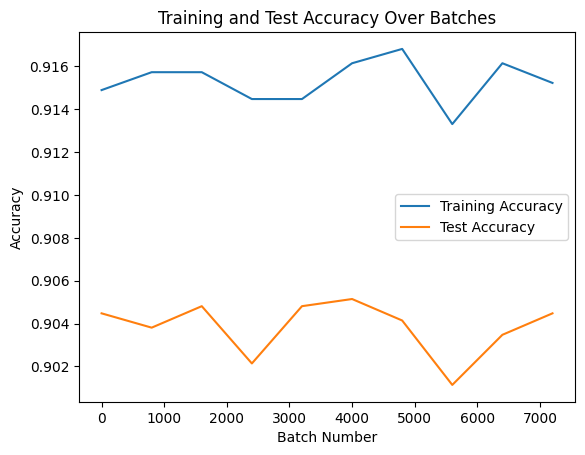

In [52]:
#εκκίνηση προσομοίωσης "λ" αρχιτεκτονικής με επανεκπαίδευση μοντέλου
model = create_and_train_model(inshape)
simulate_streaming_lambda_architecture(model, scaler)